# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [600]:
# Imports
import os.path
import random
import shutil
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [601]:
# Constants
RANDRANGE_STOP=10000
EPOCHS = 2
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 1./255
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 64
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

## Prepocessing

In [602]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    trainDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(trainDirPre):
        shutil.move(trainDirPre, '.')
        
    return topDir

In [603]:
# Pre Process Images
imgFolder = DownloadImageSet()

In [604]:
def ImageNorm(image):
    image = image/255.0
    return image

In [605]:
def Shrink(input):
    return tf.image.resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [606]:
trainSet = image_dataset_from_directory(
    directory=imgFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


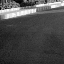

In [607]:
for batch in trainSet.take(1):
    display(array_to_img(batch[0]))

In [608]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [609]:
valSet = image_dataset_from_directory(
    directory=imgFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [610]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Create Model

In [611]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):
    convArgs = {
        'activation': 'relu',
        'kernel_initializer': 'Orthogonal',
        'padding': 'same'
    }

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=5, **convArgs)(inputs)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, **convArgs)(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=3, **convArgs)(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=3, **convArgs)(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [612]:
sr = SuperResolution()
sr.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, None, None, 64)    640       
_________________________________________________________________
conv2d_116 (Conv2D)          (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_117 (Conv2D)          (None, None, None, 4)     1156      
_________________________________________________________________
tf.nn.depth_to_space_22 (TFO (None, None, None, 1)     0         
Total params: 20,260
Trainable params: 20,260
Non-trainable params: 0
_________________________________________________________________


In [613]:
srOpt = keras.optimizers.SGD(learning_rate=0.001)
srLossFn = keras.losses.MeanSquaredError()
sr.compile(optimizer=srOpt, loss=srLossFn)

In [614]:
sr.fit(trainSet, epochs=EPOCHS, validation_data=valSet, verbose=1)

Epoch 1/2
65/65 [==============================] - 6s 86ms/step - loss: 0.2210 - val_loss: 0.2055
Epoch 2/2
65/65 [==============================] - 6s 84ms/step - loss: 0.2021 - val_loss: 0.1896
